## Import dependecies

In [1]:
import pandas as pd
import numpy as np
import cv2
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from matplotlib.image import imread
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as K
from keras import applications

## Configs

In [4]:
# Use only 1000 images when True
SUBMIT=False
DEBUG = True

# Defining which part of the model is being used
IMG = True
EXTRA_LAYERS = False
TEXT = True
PHASH = True
SIM_PHASH = True

#Defining the path to the images and properties
PATH = './data/shopee-product-matching/'
IMG_SIZE = 456 # avg img size = 444, EfficientNetB5 = 456
BATCH = 5000
IMG_SIM_THRESHOLD = 0.25
TEXT_SIM_THRESHOLD = 0.45
PHASH_SIM_THRESHOLD = 6

## Load data

In [5]:
test = pd.read_csv(PATH + 'test.csv')
train = pd.read_csv(PATH + 'train.csv')

In [6]:
if DEBUG:
    train = train.sample(n = 1000).reset_index(drop = True)

if SUBMIT: 
    img_path = PATH +"/test_images/"
    train = test 
else:
    img_path = PATH +"train_images/"
    # convert label_group to target
    tmp = train.groupby('label_group').posting_id.agg('unique').to_dict()
    train['target'] = train.label_group.map(tmp)
    train

In [7]:
train

,posting_id,image,image_phash,title,label_group,target
0,train_1646767365,1d7aadc7503b2b4539cc9a5fe41979dd.jpg,e925873ed09cd08f,Sarung celana wadimor original 100% dewasa dan...,258047,[train_1646767365]
1,train_3804237416,948a18e93f89632cf9ce7e40fa2ece1e.jpg,851ee37b0db15865,Jam Tangan Sport Pria Digital Analog Dual Time...,1033612501,[train_3804237416]
2,train_265828435,9f68c4ac50ef7c9eeaeec6b830614b93.jpg,948b1bfeceb2a141,HIASAN DINDING KALIGRAFI MUHAMMAD ALLAH PAJANG...,497228240,[train_265828435]
3,train_2391215241,0d1c2ef01101c5935c85bca9fc282a4a.jpg,eccdc3f21a9d1243,KAKILIMA READY STOCK FOCALLURE HIGH PIGMENT EY...,3949193555,[train_2391215241]
4,train_2335674199,3398edeec94be7dfb463de0bda8416aa.jpg,f4f653c96534218b,Planetamazing.Mainan Edukasi Anak Lukisan Pasi...,655689466,[train_2335674199]
...,...,...,...,...,...,...
995,train_3958775880,094f820ccae44c168b369a55ef7426bb.jpg,ceb2935a6dd2b290,Kalung Rantai 2 Layer Liontin Gembok Hati Retr...,786625962,"[train_3364925607, train_3958775880]"
996,train_1454393818,8183f96cf99ec07a340da3c00c2285c4.jpg,afb6d04d904bb6e0,USB Bluetooth Audio Receiver Wireless with Mic,1222676928,[train_1454393818]
997,train_650473256,d11ad4acfe37489595ca95b96950e88b.jpg,b6dac925c900c3f7,SOFTLENS URBAN FACTORY NORMAL,1415513193,[train_650473256]
998,train_654077291,ed05a596422b84b6afbdea8576b11fc2.jpg,ccd8284f33a1a87f,Parutan Serbaguna Multifungsi Putih 4 in 1/ Al...,3283528029,"[train_321615985, train_654077291]"


In [8]:
# images pre-processing

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, img_size=IMG_SIZE, batch_size=32, path=''): 
        self.df = df
        self.img_size = img_size
        self.batch_size = batch_size
        self.path = path
        self.indexes = np.arange( len(self.df) )
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.df) // self.batch_size
        ct += int(( (len(self.df)) % self.batch_size)!=0)
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indexes)
        return X
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        X = np.zeros((len(indexes),self.img_size,self.img_size,3),dtype='float32')
        df = self.df.iloc[indexes]
        for i,(index,row) in enumerate(df.iterrows()):
            img = cv2.imread(self.path + row['image'])
            X[i,] = cv2.resize(img,(self.img_size,self.img_size))
        return X

## Efficient Net

In [9]:
if IMG:
    
    WGT = "./models/efficientnetb5_notop.h5"
    eff_net = K.applications.EfficientNetB5(weights=WGT, input_shape=None, include_top=False, pooling="avg", drop_connect_rate=0.2)
    
    if EXTRA_LAYERS == False: model = eff_net

2022-06-26 11:50:50.136895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 11:50:50.145158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 11:50:50.145769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 11:50:50.146821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
# apply images to pre-trained model (EfficientNet)
if IMG:
    
    #chunk = BATCH 
    #cls = len(train) // chunk 
    #cls += int (len(train) % chunk != 0)
    #image_embedding = []
    #for i in tqdm(range(cls)) :

    #    a = i * chunk 
    #    b = (i+1) * chunk 
    #    b = min(b,len(train))
    #    data = DataGenerator(train.iloc[a:b], path=img_path)
    #    emb = model.predict(data, use_multiprocessing=True, workers=8)
    #    image_embedding.append(emb)

    data = DataGenerator(train, path=img_path)
    image_embedding = model.predict(data)
    
    del(model)
    gc.collect()

2022-06-26 11:51:05.705685: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-06-26 11:51:08.703691: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-06-26 11:51:11.796816: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-06-26 11:51:11.987503: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

31/32 [============================>.] - ETA: 1s

2022-06-26 11:52:10.513914: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-06-26 11:52:10.615782: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


32/32 [==============================] - 70s 2s/step


In [11]:
data.img_size

456

In [12]:
image_embedding.shape

(1000, 2048)

## Applying KNN technique

In [13]:
#IMG_SIM_THRESHOLD = 0.15
# get images prediction from nearest image embeddings

if IMG:
    
    nn = 50
    # prevent bug while submiting to kaggle
    if len(test)==3: nn = 3
    knn = NearestNeighbors(n_neighbors=6, metric ="cosine")
    knn.fit(image_embedding)
    
    chunk = BATCH
    cl = len(train) // chunk 
    cl += int((len(train) % chunk) !=0)
    pred_img = []
    for i in tqdm(range(cl)) :

        a = i * chunk
        b = (i+1) * chunk
        b = min(len(train),b)
        distances,indices = knn.kneighbors(image_embedding[a:b,])
        for j in range(b-a):
            distance = distances[j,:]
            ind = np.where(distance < IMG_SIM_THRESHOLD)[0]
            IND = indices[j,ind]
            
            ids = train.iloc[IND].posting_id.values
            near_distance = distance[ind]
            
            result = dict()
            for dist, idx in zip(near_distance, ids):
                result[idx] = dist

            pred_img.append(result)
            
            #pred_img.append(train.iloc[IND].posting_id.values)

    train["pred_img"] = pred_img

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


In [14]:
train["pred_img"]

0                    {'train_4100454281': 1.1920929e-07}
1      {'train_3752363785': 5.9604645e-08, 'train_116...
2      {'train_2375345653': 0.0, 'train_2337383154': ...
3      {'train_1839693367': 0.0, 'train_3355832936': ...
4                    {'train_1474234039': 1.1920929e-07}
                             ...                        
995                             {'train_411452928': 0.0}
996    {'train_2802783980': 1.1920929e-07, 'train_136...
997    {'train_3939884808': 1.1920929e-07, 'train_101...
998                              {'train_43858483': 0.0}
999                            {'train_4286514989': 0.0}
Name: pred_img, Length: 1000, dtype: object

In [8]:
# text pre-processing

def letters_only(text):
    return re.sub("[^a-zA-Z]", " ", text)

def lowercase_only(text):
    return text.lower()

def remove_patterns(text):
    '''
    Some titles contain " x " as separators.
    Example: train_3369186413
    '''
    patterns = {' x ': ' ',
               ' a ': ' '}
    for k, v in patterns.items():
        text = text.replace(k,v)
    return text

def replace_multispace_by_space(text):
    return re.sub('\s+',' ',text)

## There are some Indonesian words so we will
## convert those into English

#cm_map adjusted - Source of original cm_map : https://www.kaggle.com/c/shopee-product-matching/discussion/228358
cm_map = {"wanita": "woman", 
          "anak": "child", 
          "bayi": "baby",
          "tas": "bag", 
          "masker": "face mask", 
          "pria": "men",
          "murah": "cheap",
          "tangan": "hand", 
          "alat": "tool", 
          "motif": "motive", 
          "warna": "color", 
          "bahan": "material", 
          "celana": "pants", 
          "baju": "clothes", 
          "kaos": "t-shirt", 
          "sepatu": "shoes", 
          "rambut": "hair", 
          "mainan": "toy", 
          "sarung": "holster", 
          "polos": "plain", 
          "rak": "rack", 
          "botol": "bottle", 
          "sabun": "soap", 
          "kain": "fabric", 
          "panjang": "long", 
          "kabel": "cable", 
          "buku": "book", 
          "plastik": "plastic", 
          "mobil": "car", 
          "hitam": "black", 
          "karakter": "character", 
          "putih": "white", 
          "dompet": "purse", 
          "kaki": "feet", 
          "pembersih": "cleaners", 
          "lipat": "folding", 
          "silikon": "silicone", 
          "minyak": "oil", 
          "isi": "contents", 
          "paket": "package", 
          "susu": "milk", 
          "gamis": "robe", 
          "mandi": "bath", 
          "madu": "honey", 
          "kulit": "skin", 
          "serbaguna": "multipurpose", 
          "bisa": "can", 
          "kacamata": "spectacles", 
          "pendek": "short", 
          "tali": "rope", 
          "selempang": "sash",
          "topi": "hat", 
          "obat": "drug", 
          "gantungan": "hanger", 
          "tahun": "year", 
          "jilbab": "hijab", 
          "dapur": "kitchen", 
          "dinding": "wall",
          "kuas": "brush",
          "perempuan": "woman",
          "katun": "cotton", 
          "sepeda": "bike", 
          "lucu": "funny", 
          "lengan": "arm", 
          "kaca": "glass", 
          "garansi": "warranty", 
          "bunga": "flower", 
          "handuk": "towel", 
          "dewasa": "adult", 
          "elektrik": "electric", 
          "timbangan": "balance", 
          "besar": "big", 
          "bahan": "ingredient", 
          "ransel": "backpack", 
          "kertas": "paper",
          "lampu" : "light",
          "sepatu": "shoes",
          "tempat": "place"}

def translate_ind_to_eng(text):
    res = " ".join(cm_map.get(w, w) for w in text.split())    
    return res

In [9]:

# text clean up
# removed .apply(letters_only)
if TEXT:
    X = (train['title'].apply(lowercase_only)
                       .apply(remove_patterns)
                       .apply(replace_multispace_by_space)
                       .apply(translate_ind_to_eng))

In [11]:
#TEXT_SIM_THRESHOLD = 0.45
# get images prediction from nearest image embeddings

if TEXT:
    #vectorizer = CountVectorizer()
    vectorizer =  TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
    X_mat = vectorizer.fit_transform(X)

    nn = 50
    # prevent bug while submitting to kaggle
    if len(test)==3: nn = 3
    knn = NearestNeighbors(n_neighbors=3, metric ="cosine")
    knn.fit(X_mat)
    
    print(X_mat)
    # get images prediction from nearest image embeddings
    chunk = BATCH
    cl = len(train) // chunk 
    cl += int((len(train) % chunk) !=0)
    pred_text = []
    for i in tqdm(range(cl)) :
        
        

        a = i * chunk
        b = (i+1) * chunk
        b = min(len(train),b)
        distances,indices = knn.kneighbors(X_mat[a:b,])
        for j in range(b-a):
            distance = distances[j,:]
            ind = np.where(distance < TEXT_SIM_THRESHOLD)[0]
            IND = indices[j,ind]
            
            ids = train.iloc[IND].posting_id.values
            near_distance = distance[ind]
            
            result = dict()
            for dist, idx in zip(near_distance, ids):
                result[idx] = dist

            pred_text.append(result)
            #pred_text.append(train.iloc[IND].posting_id.values)

    train["pred_text"] = pred_text
    

  (0, 852)	0.2665359284580183
  (0, 1183)	0.25946365347394934
  (0, 213)	0.24937686494650527
  (0, 295)	0.21584290562190564
  (0, 342)	0.510411695733923
  (0, 112)	0.3225019077404462
  (0, 3)	0.2665359284580183
  (0, 789)	0.2211158620682208
  (0, 1161)	0.3485044677157906
  (0, 809)	0.25729380013115577
  (0, 503)	0.2841541163347177
  (1, 580)	0.3351519969377835
  (1, 1178)	0.3003578274188828
  (1, 121)	0.3666061703188352
  (1, 384)	0.3540640010248004
  (1, 130)	0.3540640010248004
  (1, 365)	0.3438163025464257
  (1, 694)	0.23718539216877818
  (1, 1027)	0.30974739121656186
  (1, 481)	0.24972756146281294
  (1, 537)	0.2820668984886754
  (2, 928)	0.4719595146020352
  (2, 800)	0.45202244405460984
  (2, 559)	0.4719595146020352
  (2, 1165)	0.3819160291150621
  :	:
  (995, 898)	0.2838563245210198
  (995, 560)	0.2911945411124984
  (995, 1143)	0.2045949965177928
  (995, 1187)	0.18572397283056433
  (995, 631)	0.3104963747918516
  (996, 1186)	0.46388752905271546
  (996, 702)	0.48032002686647407
  (9

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.07it/s]


In [18]:
train["pred_text"]

0      {'train_4100454281': 0.0, 'train_3969208198': ...
1      {'train_3752363785': 0.0, 'train_1167590611': ...
2      {'train_2375345653': 0.0, 'train_2337383154': ...
3      {'train_1839693367': 0.0, 'train_3355832936': ...
4      {'train_1474234039': 0.0, 'train_2315989780': ...
                             ...                        
995                             {'train_411452928': 0.0}
996    {'train_2802783980': 0.0, 'train_3402225365': ...
997    {'train_3939884808': 0.0, 'train_299257295': 0...
998    {'train_43858483': 0.0, 'train_2033666015': 0....
999    {'train_4286514989': 0.0, 'train_142958281': 0...
Name: pred_text, Length: 1000, dtype: object

## Performing pHash predictions

Perceptual hash (pHash), which acts as an image fingerprint. This mathematical algorithm analyzes an image's content and represents it using a 64-bit number fingerprint. Two images’ pHash values are "close" to one another if the images’ content features are similar. By comparing two image fingerprints, you can tell if they are similar.

In [19]:

# group identical phash
if PHASH:
    tmp = train.groupby('image_phash').posting_id.agg('unique').to_dict()
    train['pred_phash'] = train.image_phash.map(tmp)

In [20]:
# group similar phash
if SIM_PHASH:
    def hamming_distance(hash1, hash2):  
        return sum([c1 != c2 for c1, c2 in zip(hash1, hash2)])

    # very long to run and there's no gain compared to pred_img
    
    # check all phash with hamming distance < 6
    train['pred_phash'] = np.nan
    pred_phash = []
    for i in tqdm(range(train.shape[0])):
        train['dist'] = train['image_phash'].apply(lambda x: hamming_distance(x,train['image_phash'].iloc[i]))
        df_near = train[train['dist'] < PHASH_SIM_THRESHOLD][["posting_id","dist"]]
        
        result = dict()
        df_near.reset_index()
        for row in df_near.iterrows():
            result[row[1]["posting_id"]] = row[1]["dist"]
        #train['pred_phash'].iloc[i] =  str(result)
        pred_phash.append(result)
        
    train['pred_phash'] = pred_phash

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 92.49it/s]


## Combining text prediction and pHash

In [65]:
train

,posting_id,image,image_phash,title,label_group,target,pred_img,pred_text,pred_phash,dist
0,train_1634598069,9c487970460281b01aac17402d852b40.jpg,aee2d01d2fe2380f,innisfree my real squeeze mask ORIGINAL!,927285629,"[train_1634598069, train_1638640094]","{'train_1634598069': 0.0, 'train_1638640094': ...","{'train_1634598069': 0.0, 'train_1638640094': ...","{'train_1634598069': 0, 'train_1638640094': 0}",16
1,train_4065750643,255f311058250926c8005c22fe993cf6.jpg,eb65ad999261968a,Jam Dinding Unik Vintage Shabby Hope Burung Sw...,881579574,[train_4065750643],{'train_4065750643': 0.0},"{'train_4065750643': 0.0, 'train_911592292': 0...",{'train_4065750643': 0},13
2,train_854037625,0c5925bfdb4d466895a90ddc79bf3137.jpg,ca2813b35664ecf5,Ikat Pinggang Kulit Imitasi Aksen Lubang Tali ...,544315614,[train_854037625],{'train_854037625': 2.9802322e-07},{'train_854037625': 0.0},{'train_854037625': 0},15
3,train_2302926611,ddfab9de04a097d5f8b32c23e9c3d479.jpg,bd3dc0c26ee1491b,Somebymi aha bha pha 30 days miracle trial kit...,3823820756,[train_2302926611],"{'train_2302926611': 2.3841858e-07, 'train_246...","{'train_2302926611': 0.0, 'train_2637317264': ...",{'train_2302926611': 0},14
4,train_3628476947,a121d2de18fcab94bb2d11a1c53e280a.jpg,b281857a63a532df,[IMPOR] POKY - D1238 Tas Ransel Sport Bag Pung...,1221416124,"[train_3628476947, train_3343658924]","{'train_3628476947': 0.0, 'train_3343658924': ...","{'train_3628476947': 0.0, 'train_3343658924': ...",{'train_3628476947': 0},16
...,...,...,...,...,...,...,...,...,...,...
995,train_3629464886,6cd261ad456f3b735087950919e4f4ea.jpg,edc1923c93b33a98,Emina Glossy Stain 05 Spring Dazzle / Lip tint...,1166650192,"[train_2133053875, train_3629464886]",{'train_3629464886': 0.0},"{'train_3629464886': 0.0, 'train_2133053875': ...",{'train_3629464886': 0},11
996,train_929387095,c5d840310117f716bafd129386d392fc.jpg,ec93c73cf30c3134,Rich Dad Poor Dad (Edisi Revisi),3859736226,"[train_2421195435, train_929387095]","{'train_929387095': 0.0, 'train_2421195435': 0...","{'train_2421195435': 0.0, 'train_929387095': 0.0}","{'train_2421195435': 2, 'train_929387095': 0}",12
997,train_3592916404,dfb28dbc43cf303c30347ef1919ae02f.jpg,c58f27427b6570a3,Paling Laris Perlengpkapan Rumah Tangga Tempat...,2403031581,[train_3592916404],{'train_3592916404': 0.0},{'train_3592916404': 0.0},{'train_3592916404': 0},14
998,train_2026051218,cad644d62031d84293f5a67714045957.jpg,f0bc1d964b9aa519,Mujigae Jajangmyeon / Jjajangmyun / Jjajangmen...,3680233781,[train_2026051218],{'train_2026051218': 1.1920929e-07},{'train_2026051218': 0.0},{'train_2026051218': 0},15


In [21]:
def combine_multi_predictions(row):
    idt = row[1]["posting_id"]
    pred_phash = row[1]['pred_phash']
    pred_text = row[1]['pred_text']
    pred_img = row[1]['pred_img']
    
    pred_phash_keys = pred_phash.keys()
    pred_text_keys = pred_text.keys()
    pred_img_keys = pred_img.keys()
    
    result = dict()
    for key in pred_phash_keys:
        if key == idt:
            continue 
        value_phash = 1 - pred_phash[key] if key in pred_phash else 0
        value_text = 1 - pred_text[key] if key in pred_text else 0
        value_img = 1 - pred_img[key] if key in pred_img else 0
        
        total = value_phash + value_text + value_img
        
        result[key] = total
        
    for key in pred_text_keys:
        
        if key in result:
            continue
        
        if key == idt:
            continue 
        value_phash = 1 - pred_phash[key] if key in pred_phash else 0
        value_text = 1 - pred_text[key] if key in pred_text else 0
        value_img = 1 - pred_img[key] if key in pred_img else 0
        
        total = value_phash + value_text + value_img
        
        result[key] = total
        
    for key in pred_img_keys:
        
        if key in result:
            continue
        
        if key == idt:
            continue 
        value_phash = 1 - pred_phash[key] if key in pred_phash else 0
        value_text = 1 - pred_text[key] if key in pred_text else 0
        value_img = 1 - pred_img[key] if key in pred_img else 0
        
        total = value_phash + value_text + value_img
        
        result[key] = total
        
    return str(result)
        

    
df_near.reset_index()
results = [combine_multi_predictions(row) for row in train.iterrows()]

train["pred_combined"] = results  
# train.apply(lambda x: combine_multi_predictions(x),axis=1)

In [23]:
train["pred_combined"]

0               {'train_3969208198': 0.6405091392894742}
1               {'train_1167590611': 1.8099672198295593}
2                {'train_2337383154': 1.768852385653434}
3               {'train_3355832936': 1.4791465393170713}
4               {'train_2315989780': 0.5745422884381661}
                             ...                        
995                                                   {}
996    {'train_3402225365': 0.682909189232918, 'train...
997    {'train_299257295': 0.5737361374964326, 'train...
998             {'train_2033666015': 0.5790815452178351}
999              {'train_142958281': 0.5802081667463179}
Name: pred_combined, Length: 1000, dtype: object

In [ ]:

# def combine_predictions(row):
#     if PHASH and TEXT and IMG:
#         y = np.concatenate([row['pred_phash'], row['pred_text'], row['pred_img']])
#     if TEXT and IMG:    
#         y = np.concatenate([row['pred_text'], row['pred_img']])
#     if PHASH and TEXT:    
#         y = np.concatenate([row['pred_phash'], row['pred_text']])
#     if PHASH and IMG:    
#         y = np.concatenate([row['pred_phash'], row['pred_img']])
#     return list(np.unique(y))
                        
# train['pred'] = train.apply(lambda x: combine_predictions(x),axis=1)

In [ ]:
# if SUBMIT == False: 
#     print("f1 score for combined pred :", round(train.apply(getMetric('pred'),axis=1).mean(), 3))

## Here submission refers to the predicting the test data using the trained model

In [210]:
# def combine_pred(row):
#     if PHASH and TEXT and IMG:
#         y = np.concatenate([row['pred_phash'], row['pred_text'], row['pred_img']])
#     if TEXT and IMG:
#         y = np.concatenate([row['pred_text'], row['pred_img']]) 
#     if PHASH and TEXT:
#         y = np.concatenate([row['pred_phash'], row['pred_text']])    
#     if PHASH and IMG:    
#         y = np.concatenate([row['pred_phash'], row['pred_img']])

#     return " ".join(np.unique(y)) 

In [24]:
def displayTwoImages(img1, img2):
    filename_1 = train[train["posting_id"] == img1].values[0][1]
    img_1 = cv2.imread(img_path + filename_1)
    img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)

    filename_2 = train[train["posting_id"] == img2].values[0][1]
    img_2 = cv2.imread(img_path + filename_2)
    img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
    
    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(1,2) 

    f.set_figheight(15)
    f.set_figwidth(15)

    axarr[0].imshow(img_1)
    axarr[1].imshow(img_2)

In [25]:

submission = pd.DataFrame()

submission['posting_id'] = train['posting_id']
submission['matches'] = train['pred_combined']

submission[submission["matches"].str.len() > 10].values[1:10]

array([['train_3752363785', "{'train_1167590611': 1.8099672198295593}"],
       ['train_2375345653', "{'train_2337383154': 1.768852385653434}"],
       ['train_1839693367', "{'train_3355832936': 1.4791465393170713}"],
       ['train_1474234039', "{'train_2315989780': 0.5745422884381661}"],
       ['train_3901996972',
        "{'train_3367202428': 1.0, 'train_448121747': 0.7993475512016914}"],
       ['train_416580805', "{'train_2913339337': 0.8071602858919927}"],
       ['train_58141553', "{'train_1536090402': 0.8735726515135145}"],
       ['train_3099016720', "{'train_3061678695': 0.7719947695732117}"],
       ['train_2613418854',
        "{'train_2178865199': 0.6316356443835629, 'train_2411548606': 0.9244147539138794, 'train_4007221591': 0.7550410628318787}"]],
      dtype=object)

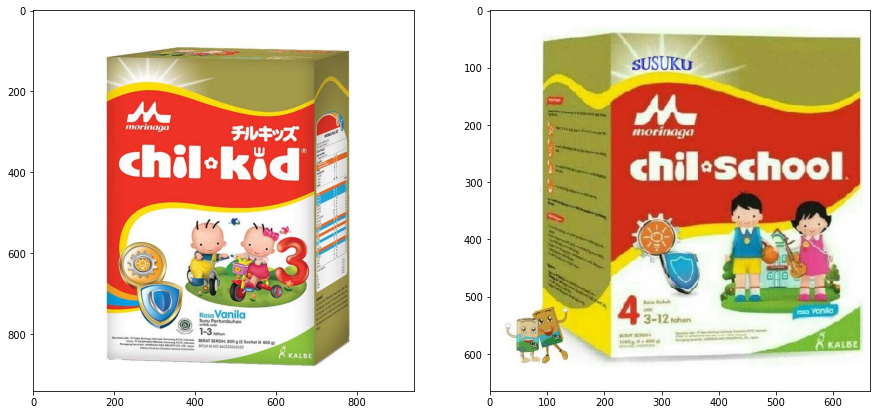

In [33]:
displayTwoImages("train_2613418854", "train_4007221591")

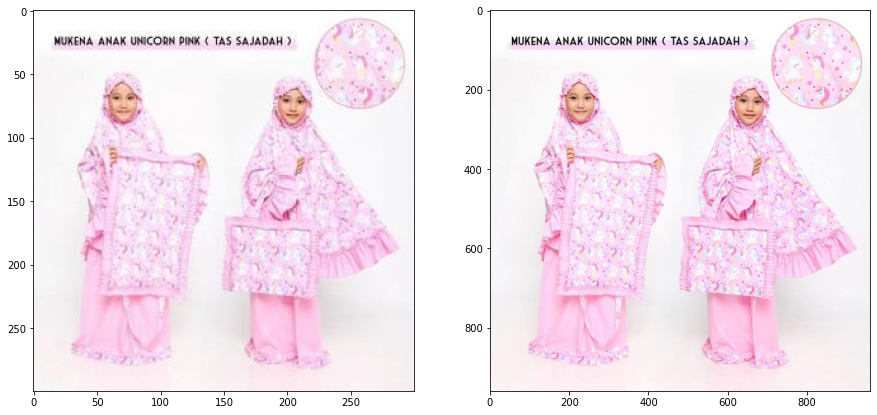

In [233]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 

f.set_figheight(15)
f.set_figwidth(15)

axarr[0].imshow(img_1)
axarr[1].imshow(img_2)